# Tree Data Preparation for Tree Explainer

lucsan - June 2021

In [83]:
import pandas as pd
import re
import numpy as np
import six
import json
import pprint

import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_text

import matplotlib.pyplot as plt
%matplotlib inline

## Read raw data and prepare it

In [27]:
df = pd.read_csv("14.08.07-annual-tree-data-file.csv")
len(df)

42226

In [28]:
keep_cols = ["Height", "Diameter", "Age Class", "Ward", "Species"]
df = df[keep_cols]

In [29]:
# Util functions

def strip_line_break(row):
    row = row.strip()
    if row == "":
        row = None
    return row
    
def strip_empty_space(row):
    if re.match(r"\s+", row):
        return None
    else:
        return row
    
def strip_measure(row):
    regex = r"(\d+\.?\d?)(\w+)"
    match = re.findall(regex, row)[0]
    if match[1] == "m":
        return float(match[0])
    elif match[1] == "cm":
        return float(match[0])/100
    else:
        print(row)
        
def extract_tree_family(row):
    return row.split()[0]

In [30]:
df = df.dropna(how="any")
df["Ward"] = df["Ward"].apply(strip_empty_space)
df = df.dropna(how="any")
df["Ward"] = df["Ward"].apply(strip_line_break)
df["Ward"] = df["Ward"].apply(lambda row: row[:-4])

In [31]:
df["Age Class"] = df["Age Class"].apply(strip_empty_space)
df = df.dropna(how="any")
df["Age Class"] = df["Age Class"].apply(strip_line_break)
df["Age Class"] = df["Age Class"].apply(lambda r: None if r=="N/A" else r)
df = df.dropna(how="any")

In [32]:
df = df.dropna(how="any")
df["Species"] = df.Species.apply(strip_line_break)
df = df.dropna(how="any")

In [33]:
df["Height"] = df.Height.apply(strip_measure)
df["Diameter"] = df.Diameter.apply(strip_measure)

In [34]:
df["Family"] = df.Species.apply(extract_tree_family)
# Remove some erroneous family names
wrong_family = ["Other", "Mixed", "Void", "Various", "Vacant"]
df = df[~df.Family.isin(wrong_family)]
df["Family"] = df.Family.apply(lambda r: "Liquidamber" if r=="Liquidambar" else r)

In [35]:
# Add the counts of species and families as columns

dict_counts_species = df.Species.value_counts().to_dict()
dict_counts_family = df.Family.value_counts().to_dict()

df["num_examples_species"] = df.Species.apply(lambda r: dict_counts_species[r])
df["num_examples_family"] = df.Family.apply(lambda r: dict_counts_family[r])

In [36]:
# Add the counts of families and age classes

dfg = df.groupby(["Family", "Age Class"]).agg({"Height": ["mean", "std"], 
                                         "Diameter": ["mean", "std"],
                                         "num_examples_family": "count"}).reset_index()

new_cols = ["Family", "Age Class", "Height_mean", "Height_std", "Diameter_mean", "Diameter_std", "num"]
dfg.columns = new_cols

In [37]:
DF = pd.merge(df, dfg, on=["Family", "Age Class"])

## Hand pick 3 families for the data set

In [38]:
# Tweak a bit the ages so that the families are somehow separable
chosen_pars = {
    "Sambucus": ["Early", "Early Mature", "Semi-Mature", "Mature"],
    "Sorbus": ["Mature"],
    "Populus": ["Mature", "Over-Mature"]
}

# Remove data points that are very far from the mean to not have crazy outliers
thr = 2
dffil = DF[(np.abs(DF.Height-DF.Height_mean)<=thr*DF.Height_std) & (np.abs(DF.Diameter-DF.Diameter_mean)<=thr*DF.Diameter_std)]

# Pick the data from the filtered data frame
dfs = []
for (fam, ages) in chosen_pars.items():
    dfsel = dffil[(dffil.Family==fam) & (dffil["Age Class"].isin(ages))]
    dfs.append(dfsel)
dfs = pd.concat(dfs)

print("Original data set size:")
print(dfs.Family.value_counts())

# Upsample the 3 families to have 600 data points on each
g = dfs.groupby(["Family"], group_keys=False)
dfs = pd.DataFrame(g.apply(lambda x: x.sample(600, replace=True).reset_index(drop=True)))

Original data set size:
Sorbus      283
Populus     200
Sambucus    124
Name: Family, dtype: int64


In [39]:
# Plotting util function
def plot_data(data):
    cols = ["tab:red", "tab:blue", "tab:green"]
    dict_cols_fam = {k: v for (k, v) in zip(dfs.Family.unique(), cols)}

    fig, ax = plt.subplots()
    grouped_fam = data.groupby('Family')
    for key, group in grouped_fam:
        group.plot(ax=ax, kind='scatter', x='Height', y='Diameter', figsize=(8,5), label=key, color=dict_cols_fam[key])
    plt.show()


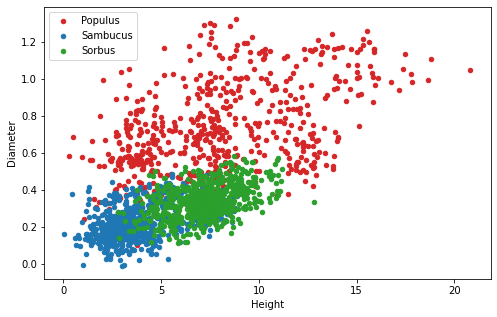

In [40]:
# Perturb Height and Diameter to get a more "random" data set
# Do it twice because it looks nicer
sigma_height = 0.6
sigma_diameter = 0.03
dfs["Height"] = dfs["Height"].apply(lambda row: row + np.random.normal(0, sigma_height))
dfs["Height"] = dfs["Height"].apply(lambda row: row + np.random.normal(0, sigma_height))

dfs["Diameter"] = dfs["Diameter"].apply(lambda row: row + np.random.normal(0, sigma_diameter))
dfs["Diameter"] = dfs["Diameter"].apply(lambda row: row + np.random.normal(0, sigma_diameter))

# Plot how it's looking like
plot_data(dfs)

## Create mini data sets for display

In [41]:
cols_to_keep = ['Height', 'Diameter', 'Family']

def create_mini_set(data, sample_size):
    g = data.groupby(["Family"], group_keys=False)
    outdata = pd.DataFrame(g.apply(lambda x: x.sample(50, replace=True).reset_index(drop=True)))
    outdata = outdata[cols_to_keep]
    return outdata

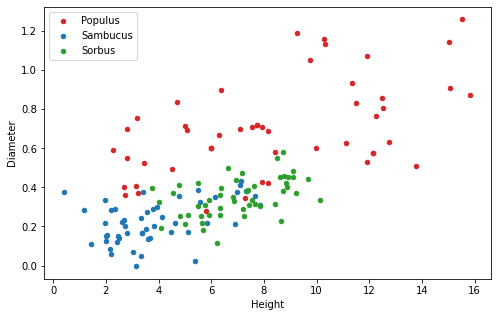

In [42]:
# One can create many different data sets with 30 points per family each. 
# We should probably set up a fixed random seed at some point
dfm = create_mini_set(dfs, 30)
plot_data(dfm)

## Save mini data to json

In [43]:
dfm.to_json('dfm.json', orient='records')

## Fit the decision tree

In [44]:
features = ["Height", "Diameter"]
x = dfs[features]
y = dfs["Family"]

In [92]:
parameters = {'max_depth': range(3,4)}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion="entropy"), parameters, n_jobs=4)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8044444444444444 {'max_depth': 3}


In [93]:
pprint.pprint(export_text(tree_model))

('|--- feature_1 <= 0.49\n'
 '|   |--- feature_0 <= 4.55\n'
 '|   |   |--- feature_1 <= 0.26\n'
 '|   |   |   |--- class: Sambucus\n'
 '|   |   |--- feature_1 >  0.26\n'
 '|   |   |   |--- class: Sambucus\n'
 '|   |--- feature_0 >  4.55\n'
 '|   |   |--- feature_1 <= 0.39\n'
 '|   |   |   |--- class: Sorbus\n'
 '|   |   |--- feature_1 >  0.39\n'
 '|   |   |   |--- class: Sorbus\n'
 '|--- feature_1 >  0.49\n'
 '|   |--- feature_1 <= 0.57\n'
 '|   |   |--- feature_0 <= 4.61\n'
 '|   |   |   |--- class: Populus\n'
 '|   |   |--- feature_0 >  4.61\n'
 '|   |   |   |--- class: Populus\n'
 '|   |--- feature_1 >  0.57\n'
 '|   |   |--- feature_1 <= 0.58\n'
 '|   |   |   |--- class: Populus\n'
 '|   |   |--- feature_1 >  0.58\n'
 '|   |   |   |--- class: Populus\n')


In [94]:
tree_model.feature_importances_

array([0.28920377, 0.71079623])

<BarContainer object of 2 artists>

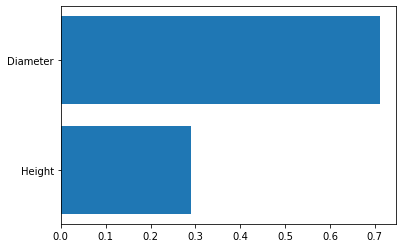

In [95]:
plt.barh(features, tree_model.feature_importances_)

## Export tree data for Explainer

In [96]:
def export_dict(decision_tree, feature_names=None):
    js = {}
    def node2str(tree, node_id, criterion):
        if not isinstance(criterion, six.string_types):
            criterion = "impurity"
        value = tree.tree_.value[node_id]
        if tree.tree_.n_outputs == 1:
            value = value[0, :]
        if tree.tree_.children_left[node_id] == sklearn.tree._tree.TREE_LEAF:
            # if terminal leafe node
            return {"id": str(node_id),
                    "impurity": str(tree.tree_.impurity[node_id]),
                    "samples": str(tree.tree_.n_node_samples[node_id]),
                    "value": str(value),
                    "majority_class":  str(value.argmax(axis=0)),
                    "leaf_node": 1
                   } 
        else:
            if feature_names is not None:
                feature = feature_names[tree.tree_.feature[node_id]]
            else:
                feature = tree.tree_.feature[node_id]
            return {"id": str(node_id),
                    'children':[],
                     "value": str(value),
                    "majority_class":  str(value.argmax(axis=0)),
                    "split_rule": f"{feature} <= {np.round(tree.tree_.threshold[node_id],2)}",
                    "feature": feature,
                    "threshold": np.round(tree.tree_.threshold[node_id], 2),
                    criterion: str(tree.tree_.impurity[node_id]),
                    "samples": str(tree.tree_.n_node_samples[node_id]),
                    "leaf_node": 0
                   } 
    def recurse(tree, node_id, criterion, parent=None):
        left_child = tree.tree_.children_left[node_id]
        right_child = tree.tree_.children_right[node_id]
        js = node2str(tree, node_id, criterion)
        # if not end node, append left and right to children
        if left_child != sklearn.tree._tree.TREE_LEAF: 
            js['children'].append(recurse(tree, left_child, criterion=criterion, parent=node_id))
            js['children'].append(recurse(tree, right_child,criterion=criterion,parent=node_id))
        return js
    if isinstance(decision_tree, sklearn.tree.DecisionTreeClassifier):
        js = recurse(decision_tree, 0, criterion="impurity")
    else:
        js = recurse(decision_tree.tree_, 0, criterion=decision_tree.criterion)
    return js

In [97]:
tt = export_dict(tree_model, features)
tt

{'id': '0',
 'children': [{'id': '1',
   'children': [{'id': '2',
     'children': [{'id': '3',
       'impurity': '0.37916366144637115',
       'samples': '373',
       'value': '[  8. 351.  14.]',
       'majority_class': '1',
       'leaf_node': 1},
      {'id': '4',
       'impurity': '1.2909692003328508',
       'samples': '136',
       'value': '[35. 85. 16.]',
       'majority_class': '1',
       'leaf_node': 1}],
     'value': '[ 43. 436.  30.]',
     'majority_class': '1',
     'split_rule': 'Diameter <= 0.26',
     'feature': 'Diameter',
     'threshold': 0.26,
     'impurity': '0.7332419483877077',
     'samples': '509',
     'leaf_node': 0},
    {'id': '5',
     'children': [{'id': '6',
       'impurity': '0.9938543045606979',
       'samples': '563',
       'value': '[ 15. 147. 401.]',
       'majority_class': '2',
       'leaf_node': 1},
      {'id': '7',
       'impurity': '1.1615305259981106',
       'samples': '193',
       'value': '[ 43.  17. 133.]',
       'majority

In [98]:
jsonfile_name = 'treedata2.json'
with open(jsonfile_name, 'w') as f:
    json.dump(tt, f)